# Dim 3 point 

The single point non-dim network leads to the emergence of the issue where some of the non-dim flux magnitudes get very large. This leads to the model not training very well. Here we do some regularization to try and deal with this. 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-02-03 20:13:15.751757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 20:13:15.771321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 20:13:15.776802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup experiment

In [5]:
# We need one place to save all the experiment relevant info.  
experiment_config= {'simulation_names':['DG'], 
                    'filter_scales':['50','100','200','400'],
                    #'filter_scales':['100'],
                    'window_size':3, 
                    'all_ml_variables' : ['dudx_widened_rotated_nondim',  # must include all variables, including those used as coefficients
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim',
                                          'mag_nabla_h_widened',
                                          'filter_scale', 
                                          'mag_nabla_u_widened',
                                          'uphp_rotated',  # this non-dim has taken a particular form (see in paper, flux/L^2/|grad u|)
                                          'vphp_rotated'], 
                    
                    'input_channels' :   ['dudx_widened_rotated_nondim',  
                                          'dvdx_widened_rotated_nondim', 
                                          'dudy_widened_rotated_nondim',
                                          'dvdy_widened_rotated_nondim',
                                          'dhdx_widened_rotated_nondim',
                                          'dhdy_widened_rotated_nondim'],
                    
                    'output_channels' :  ['uphp_rotated',
                                          'vphp_rotated'],
                    
                    'coeff_channels'  : ['filter_scale','filter_scale','mag_nabla_h_widened', 'mag_nabla_u_widened'], 

                    'extra_channels'   : [],

                    'use_coeff_channels': True,

                    'all_time_range': slice(0, 800),
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'eval_time_range' : slice(-128, -64),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    #'num_inputs': 55, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_3_point_stencil'
                    
            }
experiment_config['num_inputs'] = len(experiment_config['input_channels']) * experiment_config['window_size']**2

## SimulationData Module
#### Load data for different simulations and prepare it with right variables and non-dims.

In this step all the variables and extra dimensions may be created that were not originally present. 
Each input and output variable gets its own containing variable (e.g. if top and bottom layer were two separate inputs, then in this step they may get separated out). 
Other examples might be that rotated variables, or magnitudes become their own variables in this step. 

In [6]:
#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'], 
                             time_sel = experiment_config['all_time_range'],
                             single_layer_mask_flag=True,
                             #e_ugrad = 1e-9,
                             #e_hgrad = 1e-5
                             )

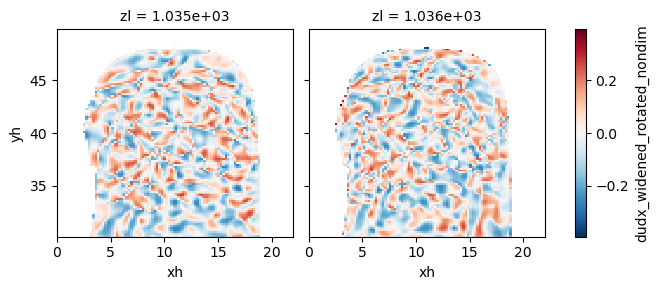

In [7]:
midpoint = int(experiment_config['window_size']/2)
DT.simulation_data['DG']['100'].dudx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

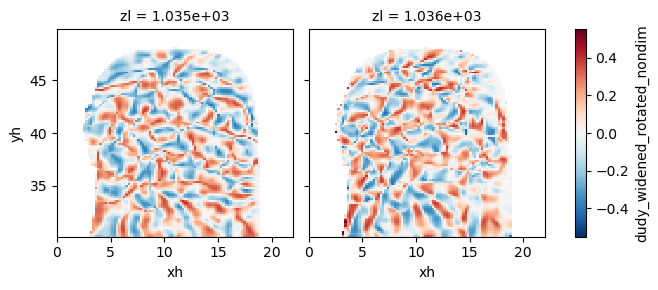

In [8]:
DT.simulation_data['DG']['100'].dudy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

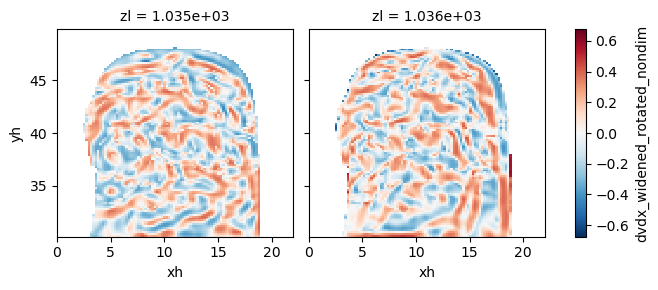

In [9]:
DT.simulation_data['DG']['100'].dvdx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

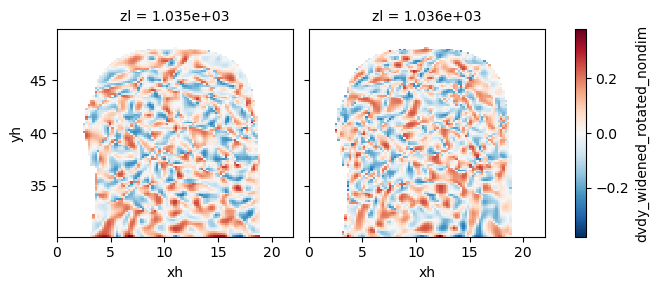

In [10]:
DT.simulation_data['DG']['100'].dvdy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

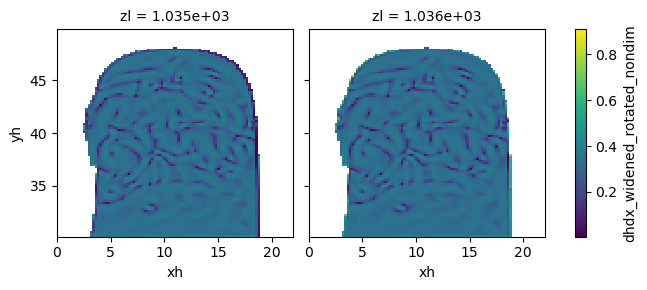

In [11]:
DT.simulation_data['DG']['100'].dhdx_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

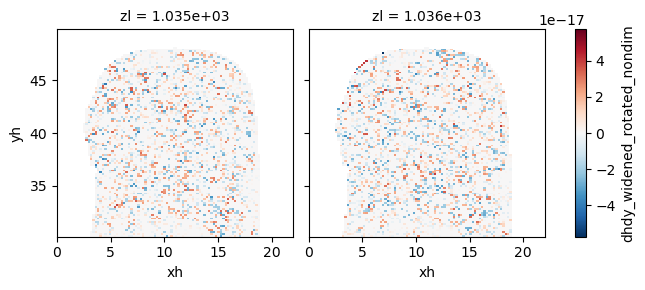

In [12]:
DT.simulation_data['DG']['100'].dhdy_widened_rotated_nondim.isel(Xn=midpoint,Yn=midpoint, Time=-1).plot(col='zl')

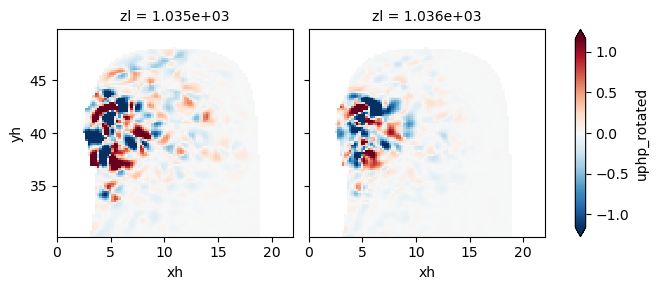

In [13]:
DT.simulation_data['DG']['100'].uphp_rotated.isel(Time=-1).plot(col='zl', robust=True)

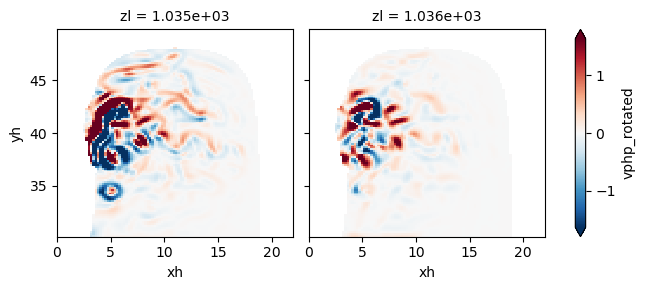

In [14]:
DT.simulation_data['DG']['100'].vphp_rotated.isel(Time=-1).plot(col='zl', robust=True)

## MLXarrayDataset 

Go from simulation data to batchesm but still as Xarray objects. 
In this step things like dropping extra points, masking of data etc happen. 

In [15]:
ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

Will load : 1.753088 gb into memory.
load took: 54.4371 seconds


In [16]:
ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 0.1753088 gb into memory.
load took: 7.1970 seconds


In [17]:
len(ML_DT_train.ml_batches), len(ML_DT_test.ml_batches) 

(37, 5)

In [18]:
ML_DT_train.ml_batches[0]

<xarray.Dataset> Size: 27MB
Dimensions:                      (Xn: 3, Yn: 3, points: 53692)
Coordinates:
  * points                       (points) object 430kB MultiIndex
  * Time                         (points) object 430kB 0009-09-06 00:00:00 .....
  * xh                           (points) float64 430kB 15.95 5.72 ... 17.66
  * yh                           (points) float64 430kB 35.36 47.09 ... 32.32
  * zl                           (points) float64 430kB 1.035e+03 ... 1.035e+03
Dimensions without coordinates: Xn, Yn
Data variables:
    dudx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB 0.1684 ... -0.0...
    dvdx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.1008 ... 0.1352
    dudy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.03975 ... 0....
    dvdy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.1713 ... 0.0...
    dhdx_widened_rotated_nondim  (Xn, Yn, points) float64 4MB 0.2953 ... 0.3176
    dhdy_widened_rotated_nondim  (Xn, Yn, points) float64 4MB -0.06659 ... 0....
    mag_nabla_h_widened          (points) float64 430kB 0.0005423 ... 0.0001851
    filter_scale                 (points) float64 430kB 9.934e+04 ... 5.056e+04
    mag_nabla_u_widened          (points) float64 430kB 1.05e-06 ... 7.196e-07
    uphp_rotated                 (points) float64 430kB 0.03428 ... -0.001064
    vphp_rotated                 (points) float64 430kB 0.03323 ... 0.001628
Attributes:
    simulation_name:  DG
    filter_scale:     50
    source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
    description:      Dataset for DG experiment at 50 km resolution

## MLJAXDataset 

### Convert these xbatcher batches to processed ones for training

This needs to take care of extra dims, like Xn,Yn.

In [19]:
batch_xr = ML_DT_train.ml_batches[0]

In [20]:
import matplotlib.pyplot as plt
import math

def plot_distributions(xr_dataset, variables):
    """
    Plots histograms for each variable in the provided dataset.

    Parameters:
    xr_dataset: xarray.Dataset
        The dataset containing the variables to be plotted.
    variables: list
        A list of variable names to be plotted.
    """
    num_vars = len(variables)
    num_cols = 2  # Adjust columns as needed
    num_rows = math.ceil(num_vars / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3 * num_rows))

    axes = axes.flatten()  # Flatten in case of multiple rows

    for i, var in enumerate(variables):
        xr_dataset[var].plot.hist(ax=axes[i])
        axes[i].set_title(var)

    # Hide unused subplots if num_vars is not a perfect multiple of num_cols
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [21]:
experiment_config['all_ml_variables']

['dudx_widened_rotated_nondim',
 'dvdx_widened_rotated_nondim',
 'dudy_widened_rotated_nondim',
 'dvdy_widened_rotated_nondim',
 'dhdx_widened_rotated_nondim',
 'dhdy_widened_rotated_nondim',
 'mag_nabla_h_widened',
 'filter_scale',
 'mag_nabla_u_widened',
 'uphp_rotated',
 'vphp_rotated']

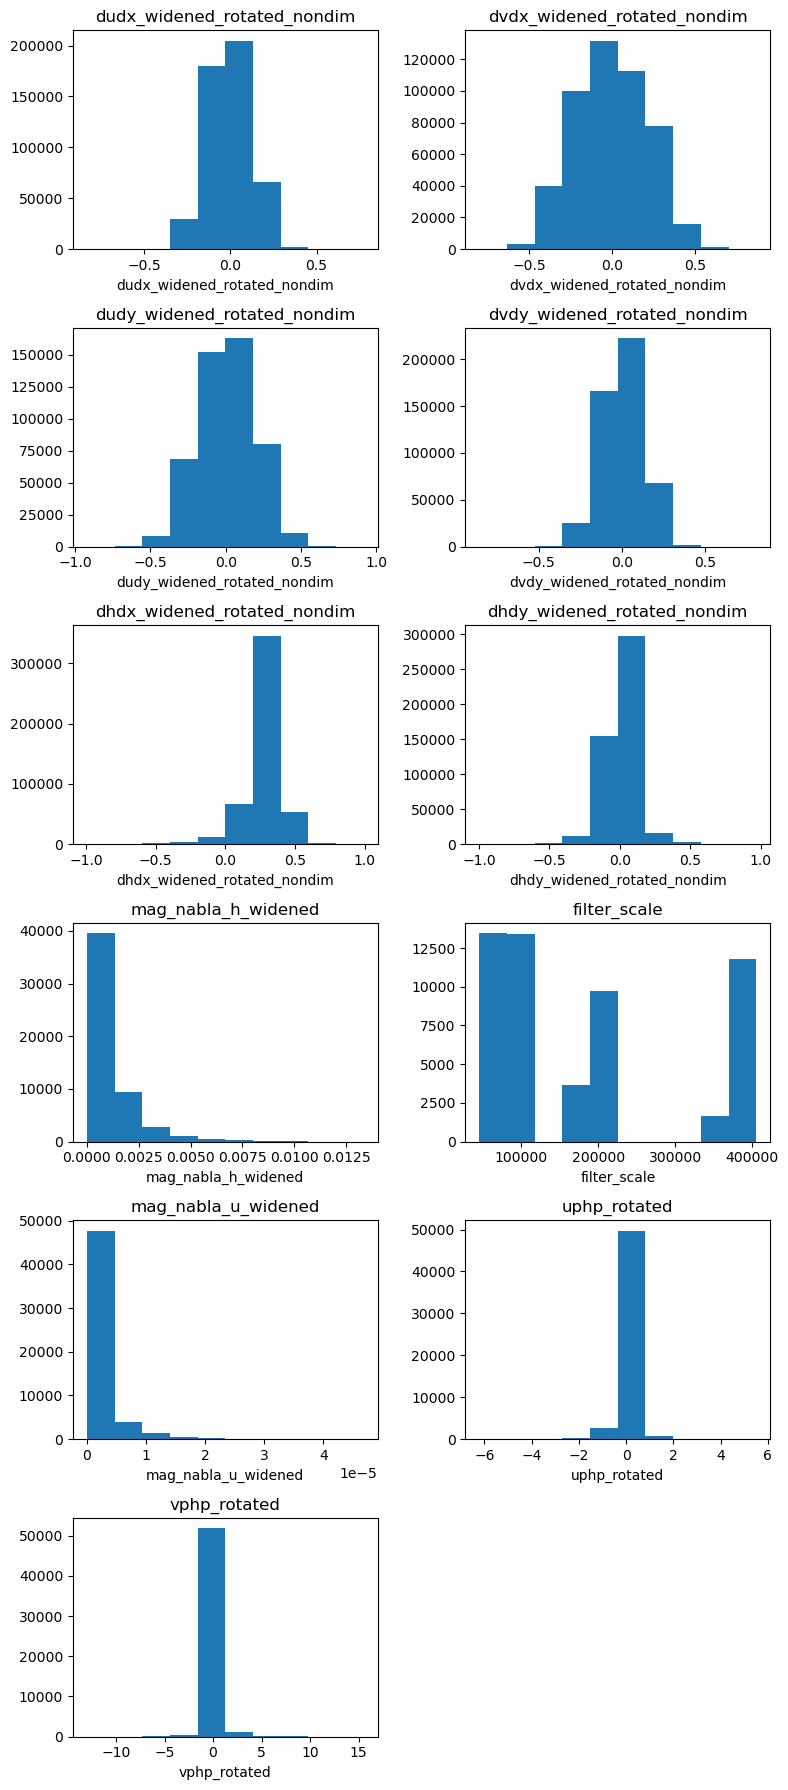

In [22]:
plot_distributions(batch_xr, experiment_config['all_ml_variables'])

In [23]:
batch_xr.std()

<xarray.Dataset> Size: 88B
Dimensions:                      ()
Data variables:
    dudx_widened_rotated_nondim  float64 8B 0.1216
    dvdx_widened_rotated_nondim  float64 8B 0.2159
    dudy_widened_rotated_nondim  float64 8B 0.1866
    dvdy_widened_rotated_nondim  float64 8B 0.1213
    dhdx_widened_rotated_nondim  float64 8B 0.1352
    dhdy_widened_rotated_nondim  float64 8B 0.1014
    mag_nabla_h_widened          float64 8B 0.001194
    filter_scale                 float64 8B 1.296e+05
    mag_nabla_u_widened          float64 8B 3.172e-06
    uphp_rotated                 float64 8B 0.3486
    vphp_rotated                 float64 8B 0.6259

In [24]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),
    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1.),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1.),
    'dudy_widened_rotated_nondim': ([], 1.),
    'dvdy_widened_rotated_nondim': ([], 1.),
    'dhdx_widened_rotated_nondim': ([], 1.),
    'dhdy_widened_rotated_nondim': ([], 1.),
    'mag_nabla_h_widened': ([], 1e-3),
    'mag_nabla_u_widened': ([], 1e-6),
    'uphp_rotated': ([], 1e-1 ),
    'vphp_rotated': ([], 1e-1 ),
    'uphp_rotated_nondim': ([], 1 / experiment_config['window_size']**4),
    'vphp_rotated_nondim': ([], 1 / experiment_config['window_size']**4),
}

# Eventually would be good to save this normalization factors dictionary with the one
# that keeps all the experiment config information. 


ds_norm = xr.Dataset(normalize_data_dic)

In [25]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      ds_norm=ds_norm)

In [26]:
test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      use_coeff_channels=experiment_config['use_coeff_channels'],
                                      ds_norm=ds_norm)

In [27]:
ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [28]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Input (Xp) batch shape:", batch_out['Xp'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (53692, 54)
Input (Xp) batch shape: (53692, 1)
Output (y) batch shape: (53692, 2)


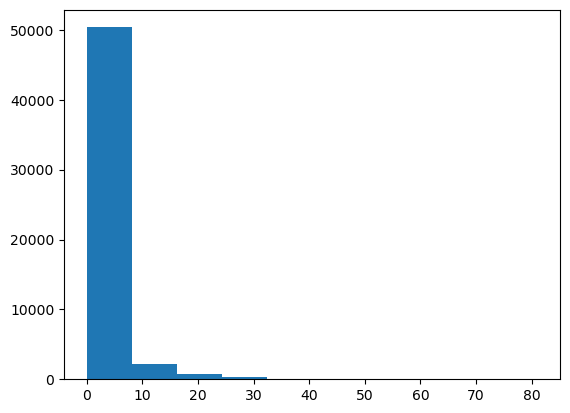

In [29]:
plt.hist(batch_out['Xp'][:,0]);

## AnnRegressionSystem (and associated NN setup modules ArtificialNeuralNetwork and PointwiseANN).


In [30]:
num_in = batch_out['X'].shape[-1]
experiment_config['num_inputs'] = num_in
experiment_config['num_inputs']

54

In [31]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [32]:
ANN_model.count_parameters()

3386


In [33]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model, loss_type='mae')

In [34]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=101, print_freq=2)

At epoch 1. Train loss :  12.446802345482078 , Test loss: 10.844197845458984 , Test R2: 0.34814666509628295
At epoch 3. Train loss :  9.010604368673789 , Test loss: 9.671329879760743 , Test R2: 0.4655205726623535
At epoch 5. Train loss :  7.965688924531679 , Test loss: 8.720684242248534 , Test R2: 0.5490342617034912
At epoch 7. Train loss :  7.579494192793563 , Test loss: 8.383922386169434 , Test R2: 0.573986554145813
At epoch 9. Train loss :  7.344651621741217 , Test loss: 8.163274002075195 , Test R2: 0.5932548761367797
At epoch 11. Train loss :  7.23236810838854 , Test loss: 8.07611961364746 , Test R2: 0.6002904891967773
At epoch 13. Train loss :  7.128046937890955 , Test loss: 7.9526349067687985 , Test R2: 0.6104953169822693
At epoch 15. Train loss :  7.04840054383149 , Test loss: 7.862903213500976 , Test R2: 0.6188451886177063
At epoch 17. Train loss :  6.992382874359956 , Test loss: 7.821497821807862 , Test R2: 0.6243589639663696
At epoch 19. Train loss :  6.95537603223646 , Test 

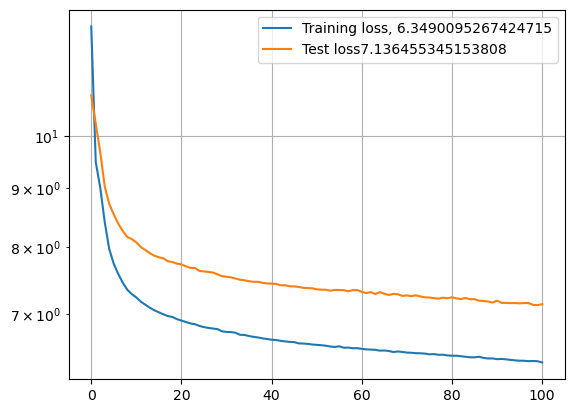

In [35]:
## Loss plot
plt.plot(regress_sys.train_loss, label='Training loss, '+str(regress_sys.train_loss[-1]))
plt.plot(regress_sys.test_loss, label='Test loss'+str(regress_sys.test_loss[-1]))

plt.grid()
plt.yscale('log')
plt.legend()

In [36]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_3_point_stencil'

In [37]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [38]:
regress_sys.state.params['params']['layers_0']['kernel']

Array([[-0.31244946,  0.00962858,  0.02023958, ...,  0.1153737 ,
        -0.22633898, -0.3169374 ],
       [ 0.7355724 , -0.19018586, -0.15327066, ..., -0.36116794,
         0.7889909 , -0.01009146],
       [-0.4352491 ,  0.03318489, -0.2366044 , ..., -0.0076022 ,
        -0.76365244,  0.16734193],
       ...,
       [ 0.33807334, -0.42776352, -0.02913995, ..., -0.18458521,
         0.17022508,  0.92100906],
       [-1.8827484 , -0.33461738,  0.03102356, ..., -0.557651  ,
         0.25545087, -1.2954476 ],
       [-0.3790728 ,  0.4986544 , -0.08440969, ...,  0.70508814,
        -0.03308425,  0.7250761 ]], dtype=float32)

Testing around saving check points 

Check if data can be reloaded in, we do this in a new object.

In [39]:
new_regress_sys =  ML_classes.AnnRegressionSystem(ANN_model)

In [40]:
new_regress_sys.read_checkpoint(experiment_config['exp_ckpt_save_dir'])

In [41]:
new_regress_sys.network.count_parameters()

3386


In [42]:
new_regress_sys.state.params['params']['layers_0']['kernel']

Array([[-0.31244946,  0.00962858,  0.02023958, ...,  0.1153737 ,
        -0.22633898, -0.3169374 ],
       [ 0.7355724 , -0.19018586, -0.15327066, ..., -0.36116794,
         0.7889909 , -0.01009146],
       [-0.4352491 ,  0.03318489, -0.2366044 , ..., -0.0076022 ,
        -0.76365244,  0.16734193],
       ...,
       [ 0.33807334, -0.42776352, -0.02913995, ..., -0.18458521,
         0.17022508,  0.92100906],
       [-1.8827484 , -0.33461738,  0.03102356, ..., -0.557651  ,
         0.25545087, -1.2954476 ],
       [-0.3790728 ,  0.4986544 , -0.08440969, ...,  0.70508814,
        -0.03308425,  0.7250761 ]], dtype=float32)

Making predictions using some batch. 

In [43]:
y_true = batch_out['y']

In [44]:
y_pred = new_regress_sys.pred(batch_out['X'], batch_out['Xp'])

In [45]:
y_pred

Array([[ 3.0701234 ,  3.0879803 ],
       [14.665722  , 43.53117   ],
       [-1.7705843 ,  7.8579245 ],
       ...,
       [-0.08369531, -0.43109107],
       [ 4.9105496 ,  0.6978766 ],
       [-0.12074712,  0.16509657]], dtype=float32)

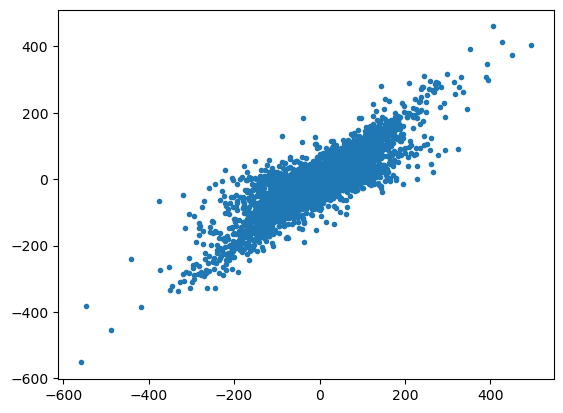

In [46]:
plt.plot(y_true[:,0], y_pred[:,0],'.')


The above prediction method works, but we would like a little more functionality. 
We want to be able to make predictions on the original grids and structure of the data (e.g. at different scales), so we can track performance in real space (rather than sample space). To do all this, we will be developing an evaluation module. 

## Evaluation Module

In [47]:
DT

In [48]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 extra_channels=experiment_config['extra_channels'],
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=experiment_config['eval_time_range'], 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'],
                                 use_coeff_channels=experiment_config['use_coeff_channels'])

In [49]:
experiment_config['exp_ckpt_save_dir']

'/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/dim_3_point_stencil'

In [50]:
test_eval.read_ann_regression_model()

In [51]:
test_eval.regress_sys.network.params['params']['layers_0']['kernel']

Array([[ 0.05199946,  0.04341472, -0.12954505, ..., -0.0504831 ,
        -0.09615247, -0.15574235],
       [-0.02738027, -0.05341689, -0.07436807, ..., -0.15101951,
        -0.10539998, -0.2016798 ],
       [ 0.11919633,  0.04156693, -0.0197169 , ..., -0.06562993,
        -0.13040678,  0.13703555],
       ...,
       [-0.15359442,  0.02019267,  0.04149942, ..., -0.06106906,
        -0.1374913 ,  0.10064273],
       [-0.08977871, -0.08219038,  0.03580662, ...,  0.01926511,
         0.01270075, -0.07990777],
       [-0.15255067, -0.00846945,  0.1635101 , ...,  0.06192549,
        -0.08716871,  0.08024892]], dtype=float32)

In [52]:
test_eval.read_eval_data()

In [53]:
test_eval.eval_datatree.ml_dataset['DG']['100']

DataTree('100', parent="DG")
    Dimensions:                      (Time: 64, zl: 2, yh: 108, xh: 100, Xn: 3,
                                      Yn: 3)
    Coordinates:
      * Time                         (Time) object 512B 0019-06-06 00:00:00 ... 0...
      * xh                           (xh) float64 800B 0.11 0.33 ... 21.67 21.89
      * yh                           (yh) float64 864B 30.27 30.45 ... 49.55 49.73
      * zl                           (zl) float64 16B 1.035e+03 1.036e+03
    Dimensions without coordinates: Xn, Yn
    Data variables:
        dudx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dudy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dvdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdx_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        dhdy_widened_rotated_nondim  (Time, zl, yh, xh, Xn, Yn) float64 100MB dask.array<chunksize=(12, 2, 107, 99, 3, 3), meta=np.ndarray>
        uphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        vphp_rotated                 (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
        filter_scale                 (yh, xh, Time) float64 6MB dask.array<chunksize=(108, 100, 12), meta=np.ndarray>
        mag_nabla_h_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        mag_nabla_u_widened          (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 107, 99), meta=np.ndarray>
        h_mask                       (Time, zl, yh, xh) float64 11MB dask.array<chunksize=(12, 2, 108, 100), meta=np.ndarray>
    Attributes:
        simulation_name:  DG
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Double_Gyre/res5...
        description:      Dataset for DG experiment at 100 km resolution

In [54]:
test_eval.predict()

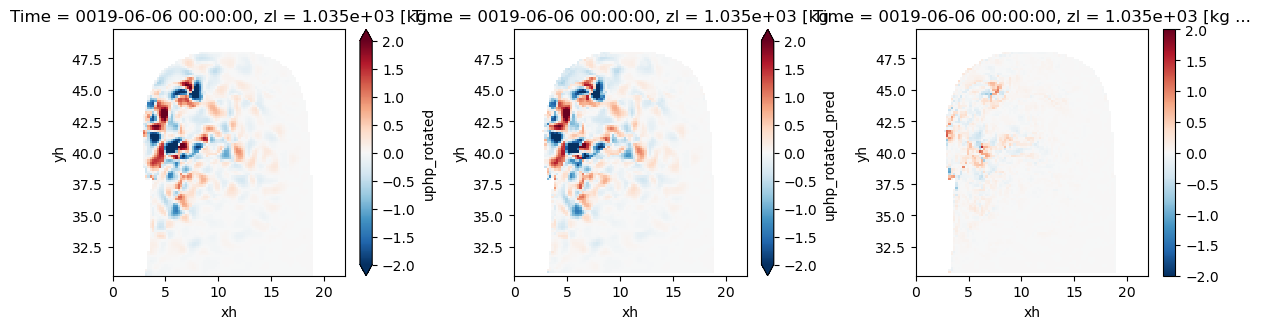

In [55]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 0
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

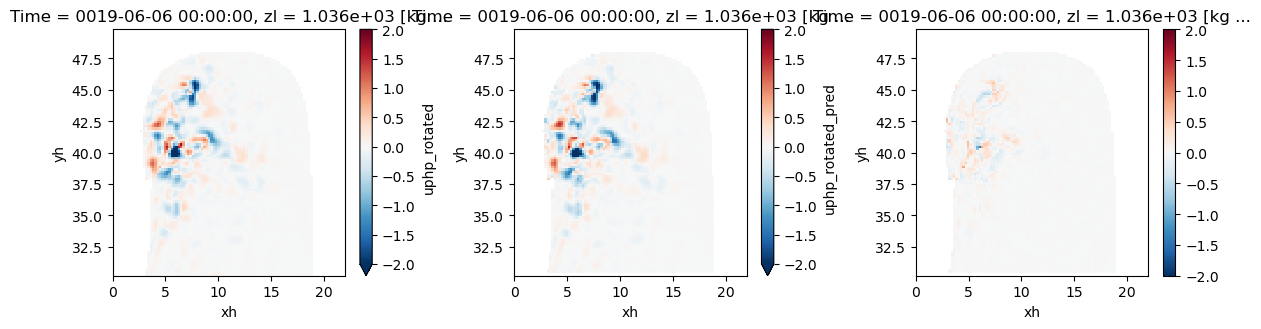

In [56]:
plt.figure(figsize=(12, 3.4))
exp_name = experiment_config['simulation_names'][0]
zl = 1
vmin = -2

plt.subplot(131)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(132)
test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl).plot(vmin=vmin)

plt.subplot(133)
(test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp_name]['100'][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl).plot(vmin=vmin)

plt.tight_layout()

In [57]:
test_eval.calc_time_hor_space_metrics(var='uphp_rotated', yh_region=slice(31, 50),descriptor='layer_wise', dims=['Time','xh','yh'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', yh_region=slice(31, 50), descriptor='layer_wise', dims=['Time','xh','yh'])


test_eval.calc_time_hor_space_metrics(var='uphp_rotated', descriptor='time', dims=['Time'])
test_eval.calc_time_hor_space_metrics(var='vphp_rotated', descriptor='time', dims=['Time'])

In [58]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+'km, R2 for uphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_layer_wise.values))
        print(exp+' '+scale+'km, R2 for vphp is (layer:[0,1])'+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_rotated_R2_layer_wise.values))

DG 50km, R2 for uphp is (layer:[0,1])[0.95852936 0.9551179 ]
DG 50km, R2 for vphp is (layer:[0,1])[0.98639109 0.97744005]
DG 100km, R2 for uphp is (layer:[0,1])[0.92511414 0.90751076]
DG 100km, R2 for vphp is (layer:[0,1])[0.97159406 0.94567182]
DG 200km, R2 for uphp is (layer:[0,1])[0.80595851 0.6284704 ]
DG 200km, R2 for vphp is (layer:[0,1])[0.89514202 0.78273706]
DG 400km, R2 for uphp is (layer:[0,1])[0.43809967 0.08310279]
DG 400km, R2 for vphp is (layer:[0,1])[0.7869251  0.32111461]


<Figure size 1200x550 with 0 Axes>

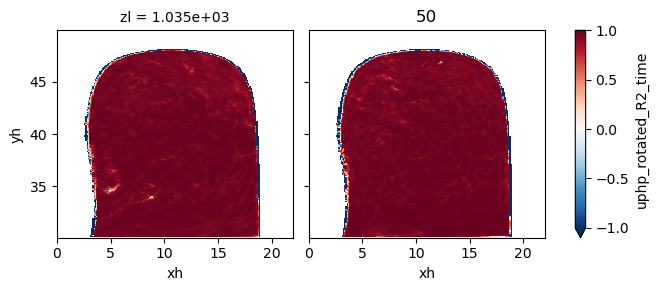

<Figure size 1200x550 with 0 Axes>

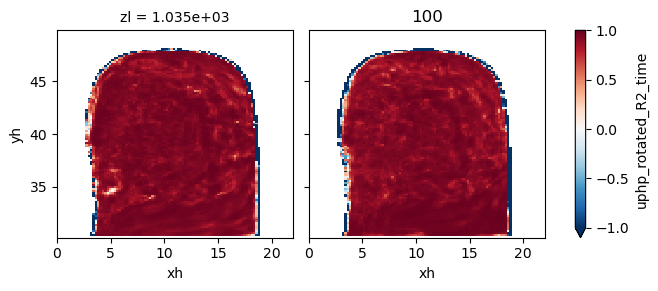

<Figure size 1200x550 with 0 Axes>

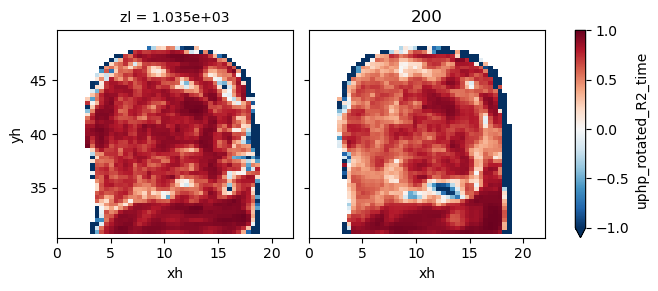

<Figure size 1200x550 with 0 Axes>

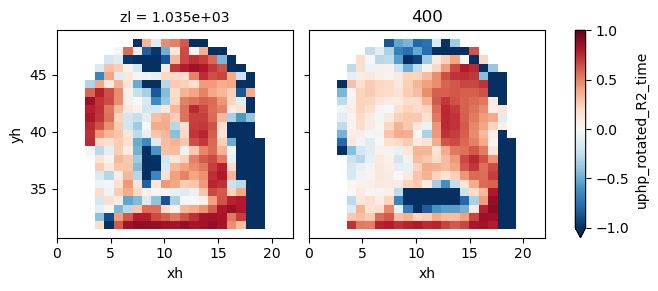

In [59]:
for scale in experiment_config['filter_scales']:

    plt.figure(figsize=(12, 5.5))

    test_eval.eval_datatree.ml_dataset[exp][scale].uphp_rotated_R2_time.plot(col='zl', vmax=1)
    plt.title(scale)